In [1]:
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

from rllr.utils.plotting.video import show_video
from rllr.utils.logger import init_logger
from rllr.utils.common import switch_reproducibility_on
from rllr.utils.plotting.display import display_stats

In [3]:
from pyhocon import ConfigFactory

config = ConfigFactory.parse_file('../experiments/conf/minigrid_navigation_mlp_master_worker.hocon')
config['env']['video_path'] = './video/'

In [4]:
switch_reproducibility_on(config['seed'])

# Train worker

In [5]:
from experiments import train_worker
init_logger('experiments.train_worker')

In [6]:
env = train_worker.gen_navigation_env(config['env'])

In [7]:
worker_agent = train_worker.get_agent(config)

2021-04-26 19:05:02,326 INFO    rllr.algo.dqn          : Running on device: cpu


In [8]:
scores, steps = train_worker.run_episodes(env, worker_agent, n_episodes=1000, verbose=100)

2021-04-26 19:06:15,211 INFO    experiments.train_worker   : Episode: 100. scores: -14.00, steps: 147.28, achieved: 0.66
2021-04-26 19:07:02,530 INFO    experiments.train_worker   : Episode: 200. scores: -8.17, steps: 91.01, achieved: 0.85
2021-04-26 19:07:26,479 INFO    experiments.train_worker   : Episode: 300. scores: -3.51, steps: 45.17, achieved: 0.92
2021-04-26 19:07:47,026 INFO    experiments.train_worker   : Episode: 400. scores: -2.78, steps: 38.37, achieved: 0.96
2021-04-26 19:07:59,934 INFO    experiments.train_worker   : Episode: 500. scores: -1.49, steps: 25.74, achieved: 0.99
2021-04-26 19:08:15,141 INFO    experiments.train_worker   : Episode: 600. scores: -1.97, steps: 30.41, achieved: 0.97
2021-04-26 19:08:24,275 INFO    experiments.train_worker   : Episode: 700. scores: -0.72, steps: 18.22, achieved: 1.00
2021-04-26 19:08:30,596 INFO    experiments.train_worker   : Episode: 800. scores: -0.16, steps: 12.59, achieved: 1.00
2021-04-26 19:08:36,490 INFO    experiments.tr

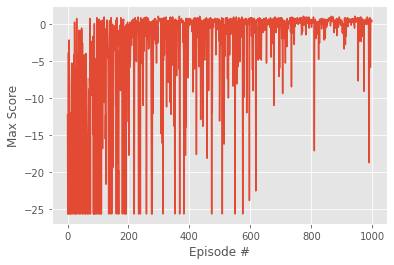

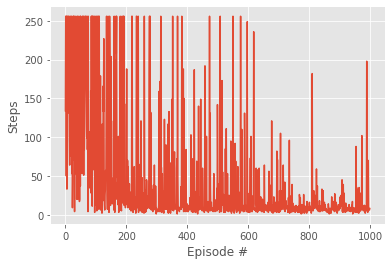

In [9]:
display_stats(scores, steps)

# Train master

In [10]:
from experiments import train_master
init_logger('experiments.train_master')

In [11]:
config = ConfigFactory.parse_file('../experiments/conf/minigrid_navigation_mlp_master_worker.hocon')
del config['env']['goal_achieving_criterion']
del config['env']['goal_type']

In [12]:
emb_size = worker_agent.qnetwork_local.state_encoder.goal_state_encoder.output_size
master_agent = train_master.get_master_agent(emb_size, config)
worker_agent.explore = False

In [13]:
env = train_worker.gen_env(config['env'])

In [15]:
scores, steps = train_master.run_episodes(env, worker_agent, master_agent, n_episodes=1000, verbose=100)

2021-04-26 19:21:54,566 INFO    experiments.train_master   : Episode: 100. scores: 0.32, steps: 180.61
2021-04-26 19:29:17,579 INFO    experiments.train_master   : Episode: 200. scores: 0.27, steps: 193.85
2021-04-26 19:36:56,514 INFO    experiments.train_master   : Episode: 300. scores: 0.27, steps: 193.50
2021-04-26 19:45:19,679 INFO    experiments.train_master   : Episode: 400. scores: 0.21, steps: 207.10
2021-04-26 19:52:54,257 INFO    experiments.train_master   : Episode: 500. scores: 0.20, steps: 209.77
2021-04-26 20:00:31,618 INFO    experiments.train_master   : Episode: 600. scores: 0.17, steps: 218.43
2021-04-26 20:08:39,366 INFO    experiments.train_master   : Episode: 700. scores: 0.12, steps: 228.75
2021-04-26 20:16:29,479 INFO    experiments.train_master   : Episode: 800. scores: 0.16, steps: 219.07
2021-04-26 20:24:50,606 INFO    experiments.train_master   : Episode: 900. scores: 0.13, steps: 224.34
2021-04-26 20:33:53,031 INFO    experiments.train_master   : Episode: 100

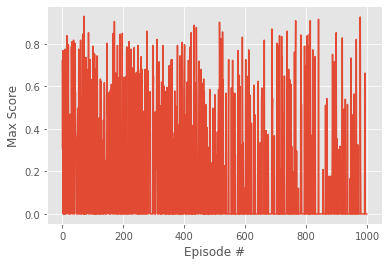

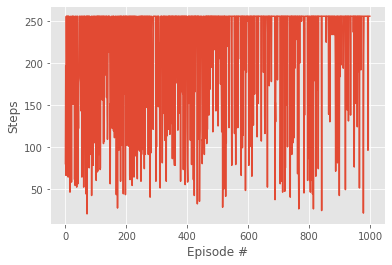

In [16]:
display_stats(scores, steps)